# Model Evaluation
Once our models have been trained, we will assess their classification performance using various evaluation metrics, including the confusion matrix, recall, precision, accuracy, f-1 scores, ROC and AUC curves.

Furthermore, we will determine the importance of each sensor in predicting each class to gain insight into the model's decision-making process (by training OneVsRestClassifier on our Random Forest model).

In [1]:
import sys
sys.path.append('..') 

In [2]:
import src.util as utils

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier

In [3]:
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'd:\\ML\\PACMANN INTRO PROJECT'

In [4]:
config = utils.load_config()

### Data and Model loading

In [5]:
clf = utils.pickle_load(config['production_model_path'])
knn_clf = utils.pickle_load(config['knn_model_path'])
X_train_feng = utils.pickle_load(config['train_feng_set_path'][0])
y_train_feng = utils.pickle_load(config['train_feng_set_path'][1])
X_test_feng = utils.pickle_load(config['test_feng_set_path'][0])
y_test_feng = utils.pickle_load(config['test_feng_set_path'][1])

### k-Fold CV Scoring on each Models
Using 5 fold of CV

In [6]:
print("k-Fold CV Score for Random Forest:")
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(clf, X_train_feng, y_train_feng, cv=cv, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

k-Fold CV Score for Random Forest:
Cross-validation scores: [0.97093791 0.97093791 0.95899471 0.97486772 0.96957672]
Mean cross-validation accuracy: 0.9690629958133261


In [7]:
print("k-Fold CV Score for kNN:")
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(knn_clf, X_train_feng, y_train_feng, cv=cv, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

k-Fold CV Score for kNN:
Cross-validation scores: [0.97622193 0.97093791 0.96164021 0.96428571 0.97486772]
Mean cross-validation accuracy: 0.9695906984546351


### Classification Report on each Models
To check precision, recall, f1-score

In [8]:
y_pred_rf = clf.predict(X_test_feng)
print("Accuracy score of the RF model (on test set):", clf.score(X_test_feng, y_test_feng))
print(classification_report(y_test_feng, y_pred_rf, target_names=config['encoder_classes']))

Accuracy score of the RF model (on test set): 0.97109375
              precision    recall  f1-score   support

     Mixture       1.00      1.00      1.00       320
       NoGas       0.94      0.95      0.94       320
     Perfume       0.95      0.94      0.94       320
       Smoke       1.00      1.00      1.00       320

    accuracy                           0.97      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.97      0.97      0.97      1280



In [9]:
y_pred_knn = knn_clf.predict(X_test_feng)
print("Accuracy score of the kNN model (on test set):", knn_clf.score(X_test_feng, y_test_feng))
print(classification_report(y_test_feng, y_pred_knn, target_names=config['encoder_classes']))

Accuracy score of the kNN model (on test set): 0.9734375
              precision    recall  f1-score   support

     Mixture       1.00      1.00      1.00       320
       NoGas       0.96      0.93      0.95       320
     Perfume       0.94      0.96      0.95       320
       Smoke       1.00      1.00      1.00       320

    accuracy                           0.97      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.97      0.97      0.97      1280



### Confusion Matrix of each Models

In [21]:
confusion_matrix(y_test_feng, y_pred_knn)

array([[320,   0,   0,   0],
       [  0, 299,  21,   0],
       [  0,  13, 307,   0],
       [  0,   0,   0, 320]], dtype=int64)

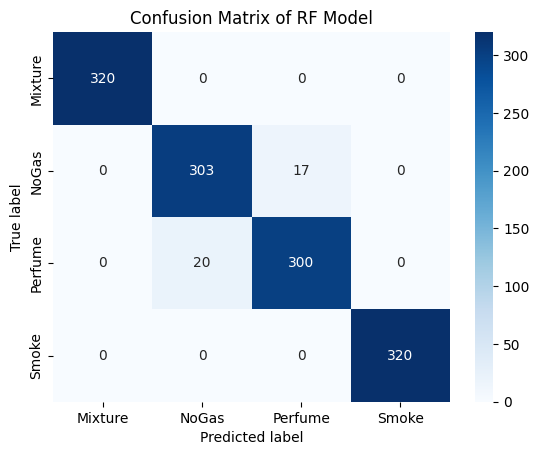

In [11]:
# confusion matrix for RF
conf_mat = confusion_matrix(y_test_feng, y_pred_rf)
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=config['encoder_classes'], yticklabels=config['encoder_classes'])
plt.title("Confusion Matrix of RF Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

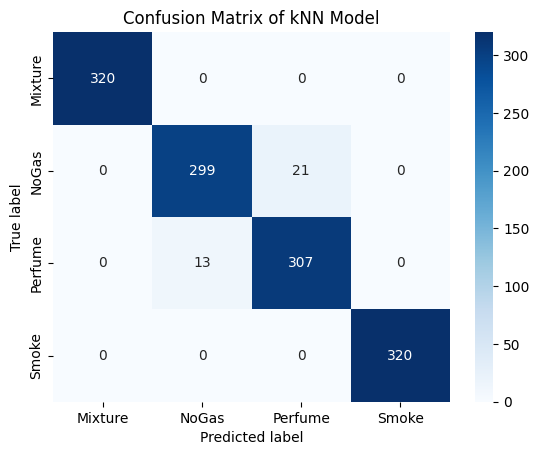

In [12]:
# confusion matrix for kNN
conf_mat = confusion_matrix(y_test_feng, y_pred_knn)
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=config['encoder_classes'], yticklabels=config['encoder_classes'])
plt.title("Confusion Matrix of kNN Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### ROC AUC Curve of each Models
Since we this is a multiclass classification task, we need to implement OvR (One-vs-Rest) or OvO (One-vs-One) to make it binary. In this case, we are using OvR approach, thus it will produce figures as muny as number of classes:
1. Mixture vs Rest
2. NoGas vs Rest
3. Perfume vs Rest
4. Smoke vs Rest

In [14]:
y_score = clf.predict_proba(X_test_feng)

n_classes = len(config['encoder_classes'])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_feng == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc

{0: 1.0, 1: 0.9944694010416667, 2: 0.993955078125, 3: 1.0}

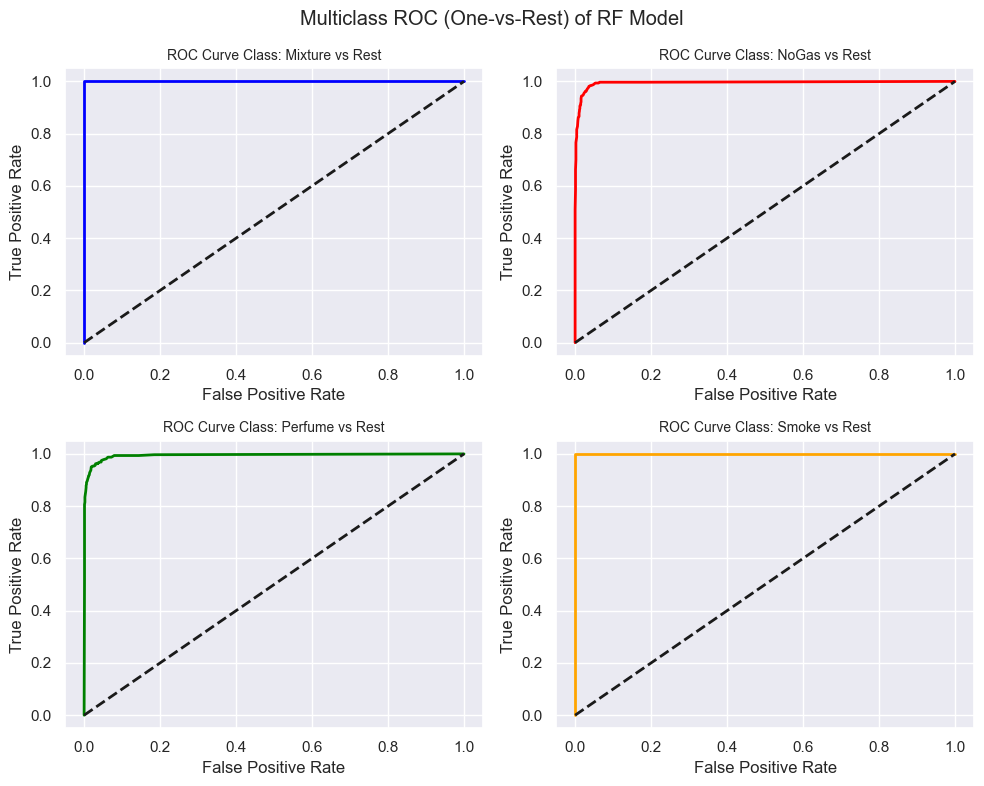

In [15]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple', 'cyan', 'magenta']

sns.set_theme()
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Multiclass ROC (One-vs-Rest) of RF Model')

for i, v in enumerate(config['encoder_classes']):
    ax = plt.subplot(2, 2, i+1)
    ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC curve of class {v} (area = {roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f'ROC Curve Class: {v} vs Rest', fontdict={'fontsize': 10})
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

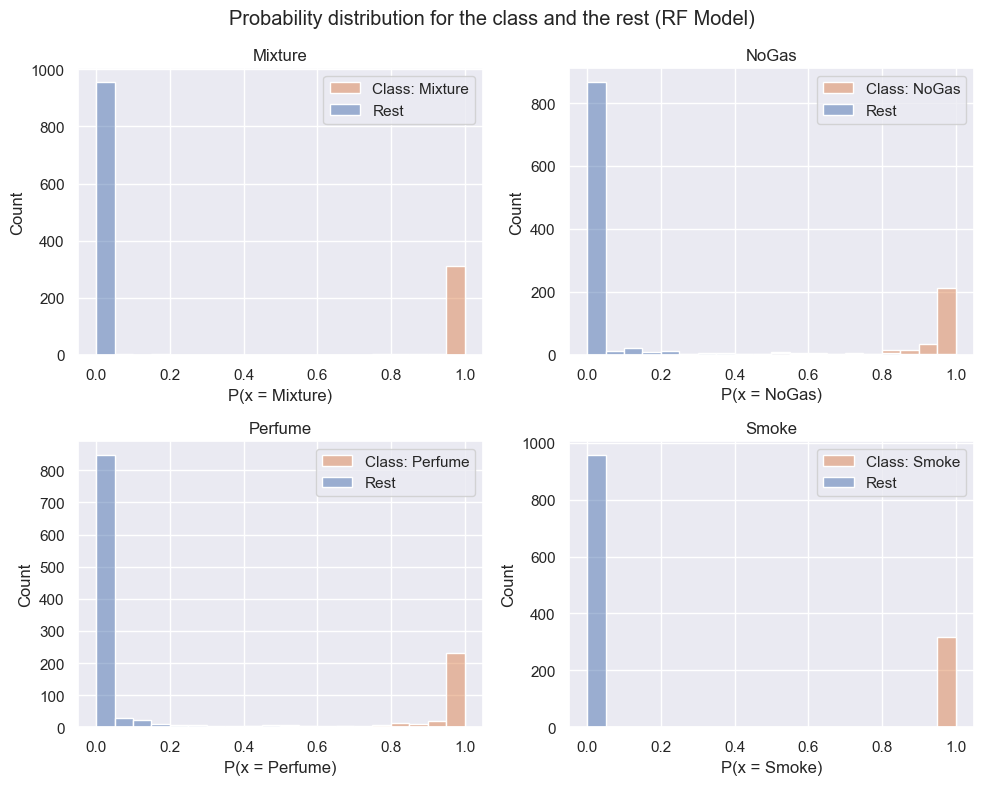

In [16]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple', 'cyan', 'magenta']
sns.set_theme()


fig = plt.figure(figsize=(10, 8))
fig.suptitle('Probability distribution for the class and the rest (RF Model)')
bins = [i/20 for i in range(20)] + [1]

for i, v in enumerate(config['encoder_classes']):
    df_aux = pd.DataFrame({'class': [1 if y == i else 0 for y in y_test_feng],
                            'prob': y_score[:, i]
                        })
    ax = plt.subplot(2, 2, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(v)
    ax.legend([f"Class: {v}", "Rest"])
    ax.set_xlabel(f"P(x = {v})")

plt.tight_layout()
plt.show()

In [17]:
y_score = knn_clf.predict_proba(X_test_feng)

n_classes = len(config['encoder_classes'])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_feng == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc

{0: 1.0, 1: 0.9917464192708334, 2: 0.9917464192708334, 3: 1.0}

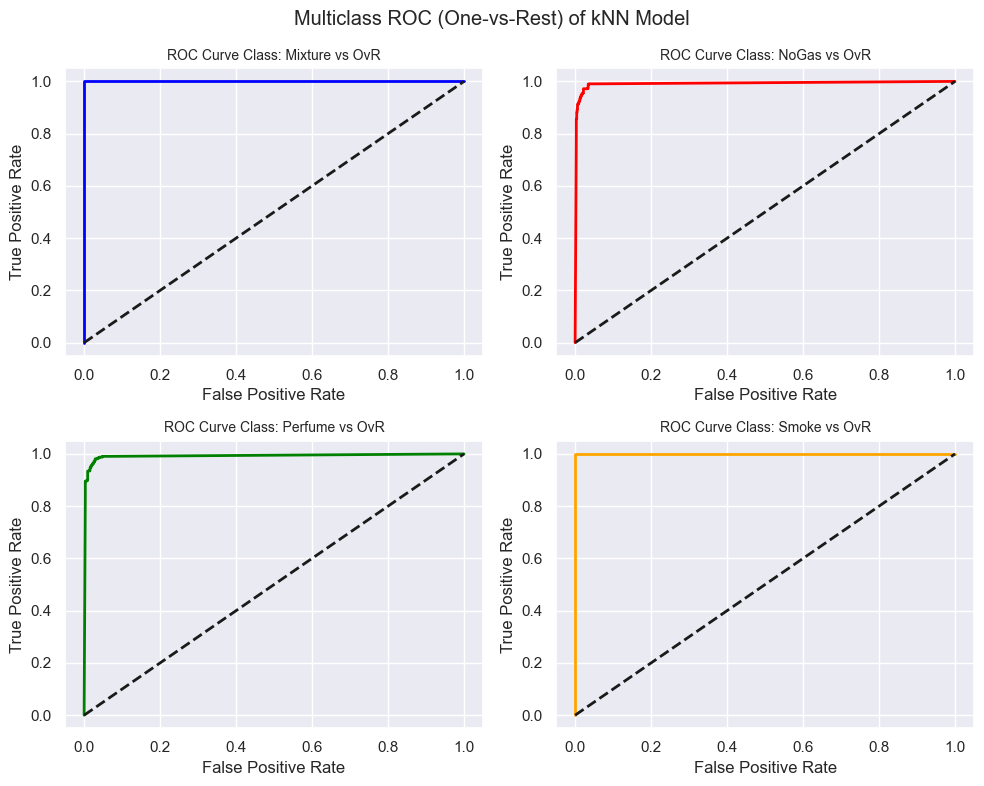

In [18]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple', 'cyan', 'magenta']

sns.set_theme()
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Multiclass ROC (One-vs-Rest) of kNN Model')

for i, v in enumerate(config['encoder_classes']):
    ax = plt.subplot(2, 2, i+1)
    ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC curve of class {v} (area = {roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_title(f'ROC Curve Class: {v} vs OvR', fontdict={'fontsize': 10})
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

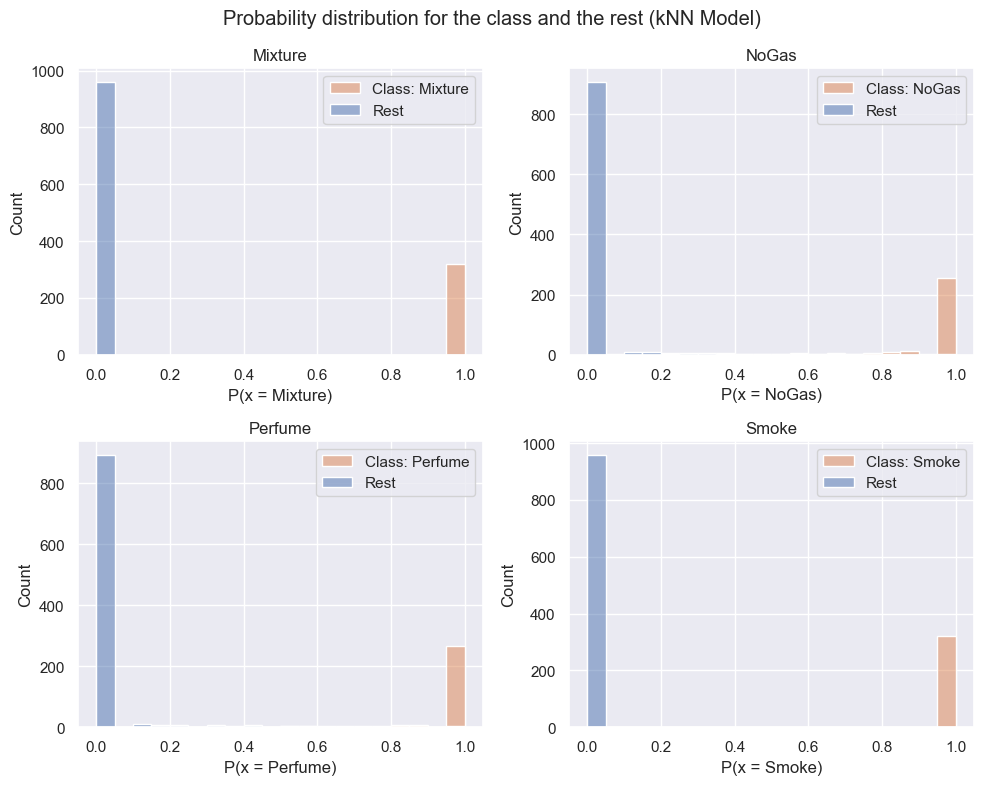

In [19]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple', 'cyan', 'magenta']
sns.set_theme()


fig = plt.figure(figsize=(10, 8))
fig.suptitle('Probability distribution for the class and the rest (kNN Model)')
bins = [i/20 for i in range(20)] + [1]

for i, v in enumerate(config['encoder_classes']):
    df_aux = pd.DataFrame({'class': [1 if y == i else 0 for y in y_test_feng],
                            'prob': y_score[:, i]
                        })
    ax = plt.subplot(2, 2, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(v)
    ax.legend([f"Class: {v}", "Rest"])
    ax.set_xlabel(f"P(x = {v})")

plt.tight_layout()
plt.show()

### Feature Importance of Each Classes

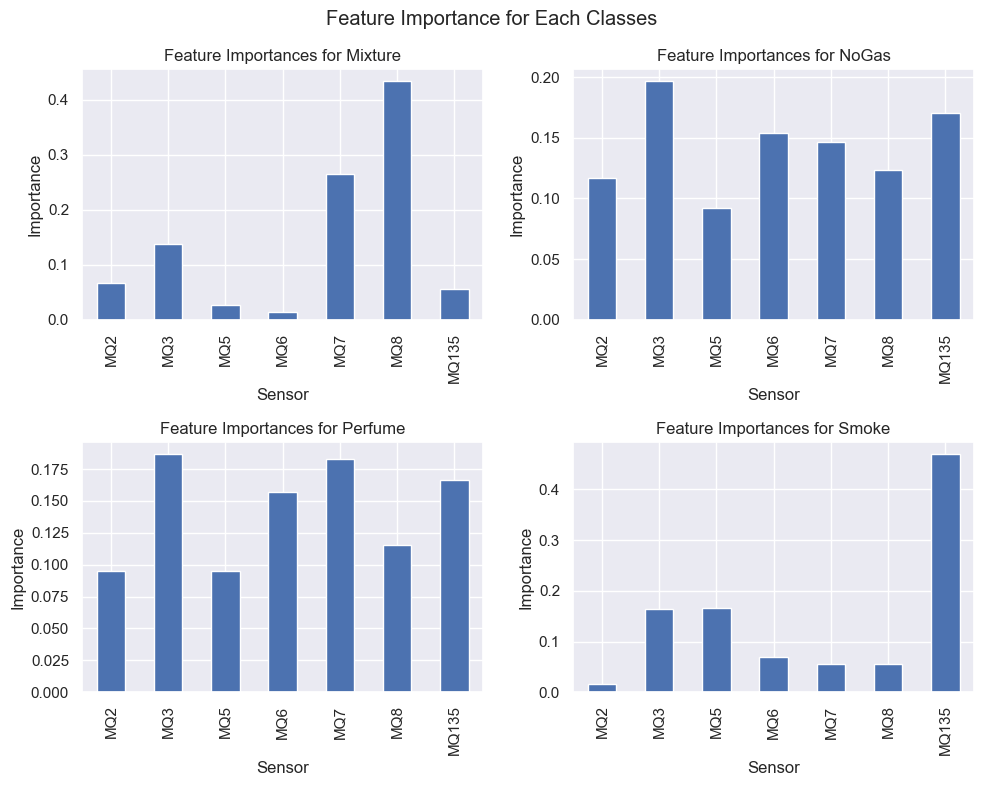

In [18]:
# Train OneVsRestClassifier with RandomForestClassifier
ovr_clf = OneVsRestClassifier(clf)
ovr_clf.fit(X_train_feng, y_train_feng)

# Create a DataFrame with feature names and importances per class
importance_df = pd.DataFrame(index=config['predictors'])

for i, estimator in enumerate(ovr_clf.estimators_):
    class_label = config['encoder_classes'][i]
    importance_df[class_label] = estimator.feature_importances_

# Plot the feature importances for each class separately
sns.set_theme()
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Feature Importance for Each Classes')

for i, (class_name, class_importances) in enumerate(importance_df.items()):
    ax = plt.subplot(2, 2, i+1)
    class_importances.plot(kind='bar', ax=ax)
    ax.set_xlabel('Sensor')
    ax.set_ylabel('Importance')
    ax.set_title(f'Feature Importances for {class_name}')

plt.tight_layout()
plt.show()

Result Analysis:
- Class 'Mixture' (Perfume + Smoke): highly affected by MQ7 and MQ8
- Class 'Smoke': highly affected by MQ135 and MQ3 (and some MQ5)

Class 'Perfume' should be highly affected only by MQ3 and MQ135, since MQ3 detects ethanol and alcohol (which contained in perfume) and MQ135 detects benzene (which might be contained in perfume as VOCs)

Meanwhile class 'NoGas' has a equally feature importance from all sensors. 

In [26]:
pd.DataFrame({'Feature': config['predictors'], 'Importance': clf.feature_importances_})

,Feature,Importance
0,MQ2,0.086913
1,MQ3,0.215399
2,MQ5,0.106109
3,MQ6,0.072807
4,MQ7,0.155281
5,MQ8,0.185317
6,MQ135,0.178174


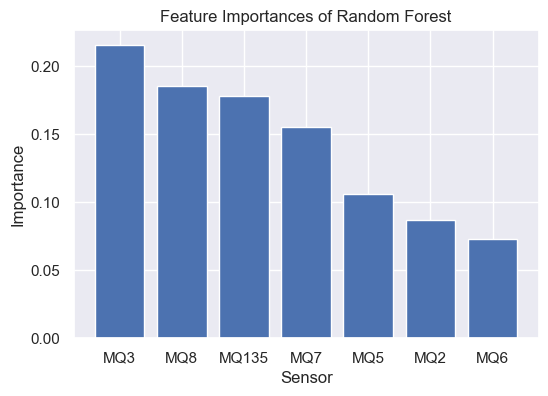

In [19]:
feature_importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': config['predictors'], 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Sensor')
plt.ylabel('Importance')
plt.title('Feature Importances of Random Forest')
plt.show()

In [20]:
utils.pickle_dump(ovr_clf, config['ovr_model_path'])